# Analyze decision threshold
We notice that some models always predict 1 for binary_A. We try modifiying the decision threshold and see the impact on validation metrics

In [61]:
import pathlib
import sys
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, fbeta_score, PrecisionRecallDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb

from src.util.definitions import PRED_DIR, DATA_ROOT
from src.util.io import read_predictions

In [2]:
api = wandb.Api()
runs = api.runs("jugoetz/synferm-predictions", filters={"group": "2023-10-19-164417_772607"})

In [3]:
config_list = [run.config for run in runs]
summary_list = [run.summary._json_dict for run in runs]
name_list = [run.name for run in runs]

In [4]:
pd.json_normalize(summary_list)

,test/recall_target_binary_A,train/recall_target_binary_C,test/accuracy_target_binary_B,test/precision_target_binary_C,train/accuracy_target_binary_B,_runtime,val/loss,train/precision_target_binary_C,test/balanced_accuracy_target_binary_A,train/balanced_accuracy_target_binary_A,...,val/f1_macro,val/recall_target_binary_C,test/accuracy_target_binary_A,val/accuracy_target_binary_A,test/avgPrecision_target_binary_A,train/avgPrecision_target_binary_A,val/recall_macro,val/accuracy_macro,test/recall_target_binary_C,_wandb.runtime
0,1.000000,0.549531,0.790761,0.680000,0.797973,34.720738,0.499286,0.646626,0.500000,0.500000,...,0.643017,0.531250,0.720109,0.900383,0.839438,0.899480,0.675075,0.762452,0.343434,33
1,1.000000,0.409639,0.810585,0.593220,0.733194,36.740618,0.514775,0.589595,0.500000,0.500000,...,0.725197,0.773196,0.763231,0.711584,0.805480,0.860540,0.894987,0.713948,0.296610,35
2,1.000000,0.660000,0.835526,0.600000,0.808195,37.463226,0.468796,0.626424,0.500000,0.500000,...,0.780459,0.548077,0.815789,0.924623,0.956283,0.875511,0.848266,0.814070,0.280000,36
3,0.933754,0.378913,0.807263,0.671429,0.790707,38.844497,0.527896,0.606485,0.540048,0.560638,...,0.640254,0.300000,0.843575,0.745327,0.934960,0.914395,0.617751,0.762461,0.376000,37
4,1.000000,0.425532,0.875000,0.439024,0.737379,33.773184,0.497580,0.595533,0.500000,0.500000,...,0.745362,0.440678,0.891827,0.733728,0.900572,0.846066,0.770148,0.760355,0.206897,32
5,1.000000,0.253096,0.784091,0.900000,0.765378,31.404564,0.440427,0.606168,0.500000,0.500000,...,0.700083,0.328358,0.827652,0.860294,0.883197,0.878182,0.689810,0.810049,0.243243,30
6,1.000000,0.530950,0.795604,0.532967,0.775334,38.455984,0.528782,0.601572,0.500000,0.500000,...,0.777789,0.678832,0.865934,0.811321,0.865214,0.863409,0.881758,0.753931,0.683099,37
7,1.000000,0.584000,0.724374,0.400000,0.771607,38.113396,0.449661,0.673432,0.500000,0.500000,...,0.813703,0.884615,0.706150,0.895082,0.764312,0.897561,0.947877,0.772678,0.207792,36
8,1.000000,0.489941,0.743869,0.408163,0.748411,30.868541,0.428300,0.652344,0.500000,0.500000,...,0.702588,0.164557,0.651226,0.915493,0.707734,0.868820,0.709173,0.852582,0.263158,30


In [5]:
name_list

['2023-10-19-164417_772607_fold8',
 '2023-10-19-164417_772607_fold7',
 '2023-10-19-164417_772607_fold6',
 '2023-10-19-164417_772607_fold5',
 '2023-10-19-164417_772607_fold4',
 '2023-10-19-164417_772607_fold3',
 '2023-10-19-164417_772607_fold2',
 '2023-10-19-164417_772607_fold1',
 '2023-10-19-164417_772607_fold0']

In [6]:
preds_val = [read_predictions(n, "val") for n in name_list]

In [7]:
preds_val[0]

,pred_0,pred_1,pred_2
idx,,,
1069,0.843739,0.784537,0.469971
1076,0.856965,0.774133,0.425115
1085,0.828216,0.715753,0.300041
1092,0.843044,0.698488,0.264165
1224,0.827639,0.738999,0.337232
...,...,...,...
31987,0.790801,0.153948,0.031254
31991,0.902901,0.781721,0.328274
32008,0.877388,0.821567,0.526285


In [8]:
df_true = pd.read_csv(DATA_ROOT / "synferm_dataset_2023-09-05_40018records.csv")

In [13]:
comb = [preds.merge(df_true[["binary_A", "binary_B", "binary_C"]], left_index=True, right_index=True) for preds in preds_val]
comb[0]

,pred_0,pred_1,pred_2,binary_A,binary_B,binary_C
1069,0.843739,0.784537,0.469971,1,1,0
1076,0.856965,0.774133,0.425115,1,1,0
1085,0.828216,0.715753,0.300041,1,1,0
1092,0.843044,0.698488,0.264165,1,1,0
1224,0.827639,0.738999,0.337232,1,1,0
...,...,...,...,...,...,...
31987,0.790801,0.153948,0.031254,1,0,0
31991,0.902901,0.781721,0.328274,1,1,0
32008,0.877388,0.821567,0.526285,1,1,0
32013,0.888144,0.812524,0.480931,1,0,0


In [91]:
bal_acc = []
f_beta = []
x = np.arange(0, 1.0001, 0.01)
for threshold in x:
    bal_acc.append(balanced_accuracy_score(comb[0]["binary_A"], (comb[0]["pred_0"] > threshold)))
    f_beta.append(fbeta_score(comb[0]["binary_A"], (comb[0]["pred_0"] > threshold), beta=0.1))

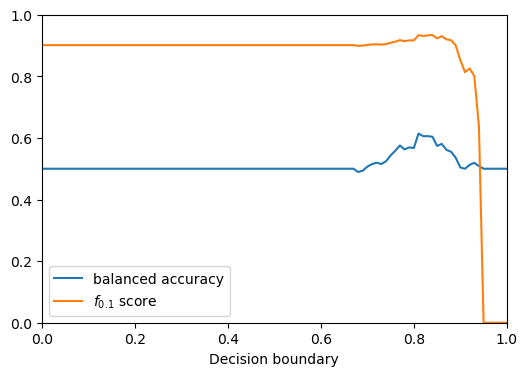

In [92]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x, bal_acc)
ax.plot(x, f_beta)
ax.set_xlabel("Decision boundary")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(["balanced accuracy", "$f_{0.1}$ score"])

In [29]:
threshold = np.argmax(bal_acc) / 100
balanced_accuracy_score(comb[0]["binary_A"], (comb[0]["pred_0"] > threshold))

0.6142389525368248

In [30]:
recall_score(comb[0]["binary_A"], (comb[0]["pred_0"] > threshold))

0.5361702127659574

In [32]:
precision_score(comb[0]["binary_A"], (comb[0]["pred_0"] > threshold))

0.9402985074626866

In [36]:
fbeta_score(comb[0]["binary_A"], (comb[0]["pred_0"] > threshold), beta=0.5)

0.8171206225680934

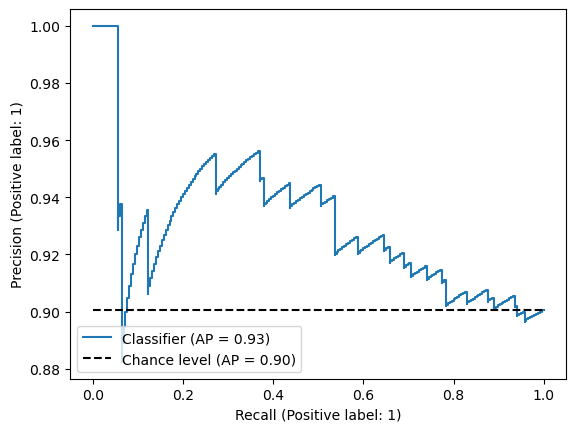

In [65]:
PrecisionRecallDisplay.from_predictions(comb[0]["binary_A"], comb[0]["pred_0"], pos_label=1, drop_intermediate=True, plot_chance_level=True)